In [1]:
import os
import sys
import json
import numpy as np

def iou(a, b):
    ax, ay, ar, ab = a
    bx, by, br, bb = b
    cross_x = max(ax, bx)
    cross_y = max(ay, by)
    cross_r = min(ar, br)
    cross_b = min(ab, bb)
    cross_w = max(0, (cross_r - cross_x) + 1)
    cross_h = max(0, (cross_b - cross_y) + 1)
    cross_area = cross_w * cross_h
    union = (ar - ax + 1) * (ab - ay + 1) + (br - bx + 1) * (bb - by + 1) - cross_area
    return cross_area / union

def nms(bboxes, threshold, confidence_index=-1):
    bboxes.sort(key=lambda x: x[confidence_index], reverse=True)
    flags = [True] * len(bboxes)
    keep = []
    for i in range(len(bboxes)):
        if not flags[i]: continue
        keep.append(bboxes[i])

        for j in range(i+1, len(bboxes)):
            if iou(bboxes[i][:4], bboxes[j][:4]) > threshold:
                flags[j] = False
    return keep

def nms_as_class(bboxes, threshold, class_index=-1, confidence_index=-2):
    boxasclass = {}
    for box in bboxes:
        classes = box[class_index]
        if classes not in boxasclass:
            boxasclass[classes] = []
        boxasclass[classes].append(box)

    output = []
    for key in boxasclass:
        result = nms(boxasclass[key], threshold, confidence_index)
        output.extend(result)
    return output

def xml_value(line):
    p0 = line.find(">") + 1
    p1 = line.find("</", p0)
    return line[p0:p1]

def xml_token(line):
    p0 = line.find("<") + 1
    p1 = line.find(">", p0)
    return line[p0:p1]

def load_voc_xml(file):

    with open(file, "r") as f:
        lines = f.readlines()

    name = None
    box = None
    bboxes = []
    enter_object = False
    enter_part = False
    for line in lines:
        token = xml_token(line)
        
        if token == "object":
            enter_object = True
        elif token == "/object":
            enter_object = False            
        elif enter_object:
            if token == "part":
                enter_part = True
            elif token == "/part":
                enter_part = False

            if not enter_part:
                if token == "name":
                    name = xml_value(line)
                elif token == "bndbox":
                    box = [name]
                    bboxes.append(box)
                elif token in ["xmin", "ymin", "xmax", "ymax"]:
                    box.append(float(xml_value(line)))
    return bboxes

def load_ann(root, call, suffix):
    files = os.listdir(root)
    anns = {}
    for file in files:
        if file.endswith(suffix):
            name = file[:file.rfind(".")]
            anns[name] = call(os.path.join(root, file))
    return anns

def load_json_ann(root):
    def call(file):
        with open(file, "r") as f:
            ann = json.load(f)
        return ann
    return load_ann(root, call, ".json")

def load_xml_ann(root, label_map):
    def call(file):
        return [item[1:] + [0, label_map.index(item[0])] for item in load_voc_xml(file)]
    return load_ann(root, call, ".xml")

In [2]:
detection_annotation_root = "predict_json"
groundtruth_annotation_root = "groundtruths_xml"
label_map = ["aeroplane", "bicycle", "bird", "boat", "bottle", "bus", "car", "cat", "chair", "cow", "diningtable", "dog", "horse", "motorbike", "person", "pottedplant", "sheep", "sofa", "train", "tvmonitor"]
detection_annotations = load_json_ann(detection_annotation_root)
groundtruth_annotations = load_xml_ann(groundtruth_annotation_root, label_map)

for image_id in detection_annotations:
    image_base_annotations = detection_annotations[image_id]
    image_base_annotations = nms_as_class(image_base_annotations, 0.5)
    detection_annotations[image_id] = image_base_annotations

In [4]:
image_id = "001278"
detection_annotations[image_id]

[[-11.189430952072144,
  -11.567875742912292,
  477.3308038711548,
  391.7403221130371,
  0.041872620582580566,
  7.0],
 [13.804018497467041,
  -14.826655387878418,
  506.9807767868042,
  376.5936493873596,
  0.014223038218915462,
  6.0]]

In [5]:
groundtruth_annotations[image_id]

[[2.0, 1.0, 500.0, 351.0, 0, 18]]

### 1.干活时候的confidence阈值，一般比如说是0.5、0.3，是为了使用
### 2.评估模型时的confidence阈值，一般是0.001、0.01之类的，非常小
- 为什么？
- 大家都采用非常底的阈值，保留尽可能多的框，统一的原则进行评估，避免不同模型，confidence阈值不同，无法统一标准

In [6]:
compute_classes_index = 0

# 构建matched_table
* 格式是：[confidence, matched_iou, matched_groundtruth_index, image_id]

In [29]:
def iou(a, b):
    '''
    a : 4 x M x 1    left, top, right, bottom
    b : 4 x 1 x N    left, top, right, bottom
    '''
    aleft, atop, aright, abottom = [a[i] for i in range(4)]
    bleft, btop, bright, bbottom = [b[i] for i in range(4)]
    
    # aleft.shape = M, 1
    # bleft.shape = 1, N
    cross_left = np.maximum(aleft, bleft)        # M x N
    cross_top = np.maximum(atop, btop)           # M x N
    cross_right = np.minimum(aright, bright)     # M x N
    cross_bottom = np.minimum(abottom, bbottom)  # M x N
    
    # cross_area.shape  =  M x N
    cross_area = (cross_right - cross_left + 1).clip(0) * (cross_bottom - cross_top + 1).clip(0)
    
    # union_area.shape  =  M x N
    union_area = (aright - aleft + 1) * (abottom - atop + 1) + (bright - bleft + 1) * (bbottom - btop + 1) - cross_area
    
    # M x N
    return cross_area / union_area

In [79]:
matched_table = []
sum_groundthruth = 0

for image_id in groundtruth_annotations:
    
    groundtruth_box = groundtruth_annotations[image_id]
    detection_box = detection_annotations[image_id]
    
    # 挑取指定类别（compute_classes_index）的box出来
    groundtruth_box = list(filter(lambda x: x[-1] == compute_classes_index, groundtruth_box))
    detection_box = list(filter(lambda x: x[-1] == compute_classes_index, detection_box))
    sum_groundthruth += len(groundtruth_box)
    
    if len(groundtruth_box) == 0:
        for detection_index in range(len(detection_box)):
            matched_index = -1
            iou_value = 0
            confidence = detection_box[detection_index][4]
            matched_table.append([confidence, iou_value, matched_index, image_id])
        continue
    
    if len(detection_box) == 0:
        continue
        
    # N x 6 (left, top, right, bottom, 0, class_index)
    groundtruth_box = np.array(groundtruth_box)
    
    # N x 6 (left, top, right, bottom, confidence, class_index)
    detection_box = np.array(detection_box)
    
    sgt = groundtruth_box.T.reshape(6, -1, 1)  # 6 x M x 1
    sdt = detection_box.T.reshape(6, 1, -1)    # 6 x 1 x N
    
    # num_groundtruth x num_detection
    matched_iou = iou(sgt, sdt)
    
    for detection_index in range(len(detection_box)):
        matched_index = matched_iou[:, detection_index].argmax()
        iou_value = matched_iou[matched_index, detection_index]
        confidence = detection_box[detection_index, 4]
        matched_table.append([confidence, iou_value, matched_index, image_id])

matched_table = sorted(matched_table, key=lambda x:x[0], reverse=True)

In [80]:
matched_table[:10]

[[0.9423317909240723, 0.712588290494865, 0, '009329'],
 [0.9255480170249939, 0.8816558261119185, 0, '007403'],
 [0.9168242812156677, 0.9117074880579924, 0, '001126'],
 [0.9092625975608826, 0.9145634697725846, 0, '002908'],
 [0.9072845578193665, 0.8018974517723729, 0, '004680'],
 [0.9016928672790527, 0.7523156813153937, 0, '002014'],
 [0.9016156196594238, 0.8589403037786615, 0, '008881'],
 [0.8957498669624329, 0.7255727715464821, 0, '009167'],
 [0.8921591639518738, 0.8721837634620767, 0, '008950'],
 [0.8904922604560852, 0.7163512422678984, 0, '009211']]

# 计算IoU阈值为0.5时的AP的Precision、Recall

In [81]:
iou_threshold = 0.5
num_detection = len(matched_table)
true_positive = np.zeros((num_detection,))

# matched_index -> 0, 1, 2, 3, 4, 5

groundtruth_seen_map = {item[3] : set() for item in matched_table}
for index in range(num_detection):
    confidence, iou_value, matched_index, image_id = matched_table[index]
    
    # 第一条件，满足iou_value > iou_threshold时，认为匹配
    if iou_value >= iou_threshold:
        # 第二条件，要求，image_id上的matched_index，第一次出现（或者说没有出现过）
        
        # 获取指定图像的seen_map，用以区分是否第一次出现某个matched_index
        image_base_seen_map = groundtruth_seen_map[image_id]
        
        if matched_index not in image_base_seen_map:
            true_positive[index] = 1
            image_base_seen_map.add(matched_index)

In [83]:
tpcount = np.cumsum(true_positive)
detection_count = np.arange(1, num_detection + 1)
precision = tpcount / detection_count
recall = tpcount / sum_groundthruth

In [84]:
import matplotlib.pyplot as plt

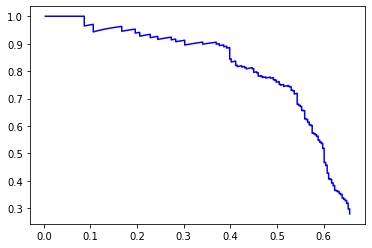

In [85]:
plt.plot(recall, precision, "b-")

# 平滑precision曲线
* Compute the precision envelope

In [96]:
# right_to_left_precision = np.flip(precision)
# acc_precision = np.maximum.accumulate(right_to_left_precision)
# acc_precision = np.flip(acc_precision)

mrec = np.concatenate(([0.], recall, [min(recall[-1] + 1E-3, 1.)]))
mpre = np.concatenate(([0.], precision, [0.]))
mpre = np.flip(np.maximum.accumulate(np.flip(mpre)))

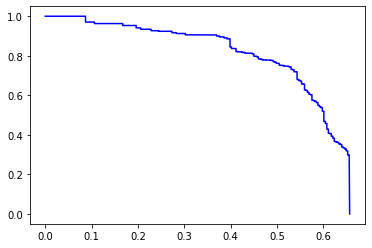

In [97]:
#plt.plot(mrec, precision, "r-")
plt.plot(mrec, mpre, "b-")

# 获取曲线下面积
* 第一种是101点法，COCO常用的方法

In [99]:
#np.interp?

In [100]:
x = np.linspace(0, 1, 101)
ap = np.mean(np.interp(x, mrec, mpre))
print(ap)

0.5450250955933796


# 集成代码

In [108]:
def iou(a, b):
    '''
    a : 4 x M x 1    left, top, right, bottom
    b : 4 x 1 x N    left, top, right, bottom
    '''
    aleft, atop, aright, abottom = [a[i] for i in range(4)]
    bleft, btop, bright, bbottom = [b[i] for i in range(4)]
    
    # aleft.shape = M, 1
    # bleft.shape = 1, N
    cross_left = np.maximum(aleft, bleft)        # M x N
    cross_top = np.maximum(atop, btop)           # M x N
    cross_right = np.minimum(aright, bright)     # M x N
    cross_bottom = np.minimum(abottom, bbottom)  # M x N
    
    # cross_area.shape  =  M x N
    cross_area = (cross_right - cross_left + 1).clip(0) * (cross_bottom - cross_top + 1).clip(0)
    
    # union_area.shape  =  M x N
    union_area = (aright - aleft + 1) * (abottom - atop + 1) + (bright - bleft + 1) * (bbottom - btop + 1) - cross_area
    
    # M x N
    return cross_area / union_area


def compute_ap(matched_table, iou_threshold, sum_groundthruth):
    num_detection = len(matched_table)
    true_positive = np.zeros((num_detection,))

    # 计算true_positive
    groundtruth_seen_map = {item[3] : set() for item in matched_table}
    for index in range(num_detection):
        confidence, iou_value, matched_index, image_id = matched_table[index]

        # 第一条件，满足iou_value > iou_threshold时，认为匹配
        if iou_value >= iou_threshold:
            # 第二条件，要求，image_id上的matched_index，第一次出现（或者说没有出现过）

            # 获取指定图像的seen_map，用以区分是否第一次出现某个matched_index
            image_base_seen_map = groundtruth_seen_map[image_id]

            if matched_index not in image_base_seen_map:
                true_positive[index] = 1
                image_base_seen_map.add(matched_index)
                
    # 计算Precision、Recall
    tpcount = np.cumsum(true_positive)
    detection_count = np.arange(1, num_detection + 1)
    precision = tpcount / detection_count
    recall = tpcount / sum_groundthruth
    
    # 平滑曲线
    mrec = np.concatenate(([0.], recall, [min(recall[-1] + 1E-3, 1.)]))
    mpre = np.concatenate(([0.], precision, [0.]))
    mpre = np.flip(np.maximum.accumulate(np.flip(mpre)))
    
    # 插值计算101点的平均值，COCO格式
    x = np.linspace(0, 1, 101)
    ap = np.mean(np.interp(x, mrec, mpre))
    return ap


def compute_map(groundtruth_annotations, detection_annotations, label_map):
    
    aps = []
    for compute_classes_index in range(len(label_map)):
        matched_table = []
        sum_groundthruth = 0

        for image_id in groundtruth_annotations:

            groundtruth_box = groundtruth_annotations[image_id]
            detection_box = detection_annotations[image_id]

            # 挑取指定类别（compute_classes_index）的box出来
            groundtruth_box = list(filter(lambda x: x[-1] == compute_classes_index, groundtruth_box))
            detection_box = list(filter(lambda x: x[-1] == compute_classes_index, detection_box))
            sum_groundthruth += len(groundtruth_box)

            if len(groundtruth_box) == 0:
                for detection_index in range(len(detection_box)):
                    matched_index = -1
                    iou_value = 0
                    confidence = detection_box[detection_index][4]
                    matched_table.append([confidence, iou_value, matched_index, image_id])
                continue

            if len(detection_box) == 0:
                continue

            # N x 6 (left, top, right, bottom, 0, class_index)
            groundtruth_box = np.array(groundtruth_box)

            # N x 6 (left, top, right, bottom, confidence, class_index)
            detection_box = np.array(detection_box)

            sgt = groundtruth_box.T.reshape(6, -1, 1)  # 6 x M x 1
            sdt = detection_box.T.reshape(6, 1, -1)    # 6 x 1 x N

            # num_groundtruth x num_detection
            matched_iou = iou(sgt, sdt)

            for detection_index in range(len(detection_box)):
                matched_index = matched_iou[:, detection_index].argmax()
                iou_value = matched_iou[matched_index, detection_index]
                confidence = detection_box[detection_index, 4]
                matched_table.append([confidence, iou_value, matched_index, image_id])

        matched_table = sorted(matched_table, key=lambda x:x[0], reverse=True)
        ap05  = compute_ap(matched_table, 0.5, sum_groundthruth)
        ap075 = compute_ap(matched_table, 0.75, sum_groundthruth)
        ap05095 = np.mean([compute_ap(matched_table, t, sum_groundthruth) for t in np.arange(0.5, 1.0, 0.05)])
        aps.append([ap05, ap075, ap05095])
    return np.mean(aps, axis=0)

In [109]:
map = compute_map(groundtruth_annotations, detection_annotations, label_map)

In [113]:
names = ["0.5", "0.75", "0.5:0.95"]

for ap, name in zip(map, names):
    print(f"AP @ [IoU={name:8s}] = {ap:.3f}")

AP @ [IoU=0.5     ] = 0.509
AP @ [IoU=0.75    ] = 0.262
AP @ [IoU=0.5:0.95] = 0.271


# 总结
1. mAP的计算大流程步骤分为：
    * A. 构建matched_table
        - 列的定义是：confidence, max_matched_iou, matched_index, image_id
        - 行的定义是：指定类别下的所有检测框的总数
        - 基于confidence对matched_table进行排序
    * B. 计算Precision和Recall
        - 计算true_positive，也就是TP
            - 第一个条件：max_matched_iou > threshold(指定的阈值)
            - 第二个条件：matched_index是第一次出现（seen）
            - 满足2个条件后，则认为是TP。然后将matched_index设置为见过（seen）
            - 计算Precision和Recall的公式：
                - $Precision = \frac{TP}{TP + FP}$
                - $Recall = \frac{TP}{TP + FN}$
                - 要点，是转换为groundtruths的数量，和detections的数量
                    - 为什么可以转换？
                    - 因为预测没有Negative，GroundTruth也没有Negative
                    - 因此，可以只需要计算TP即可。FP、FN都不需要算
                - np.cumsum函数，实现累积和，例如[1, 2, 0, 1]返回[1, 3, 3, 4]
            - 平滑Precision曲线
                - 先增加头尾，precision在前后各增加一个0，recall前面加0，后面recall[-1] + 1e-3
                - Compute the precision envelope
                - 计算曲线的包裹曲线，因为Precision会存在忽大忽小。让其填充凹下去的区域
                - np.maximum.accumulate，实现平滑计算
                    - 例如 x = [1, 1, 0, 2, 0, 0]，返回[1, 1, 1, 2, 2, 2]
                - np.flip，翻转数组
                    - 利用flip翻转，配合np.maximum.accumulate实现需求
    * C. 计算曲线下面积，得到AP
        - 第一种方法：11点插值法(VOC2007)
        - 第二种方法：101点插值法(COCO)
            - 提到一个新函数：np.interp(x, xp, fp, left, right, period=None)
                - 实现线性插值操作，例如:
                    - xp = 0, 10, 30
                    - fp = 30, 28, 0
                    - x = 5, 20
                    - y = np.interp(x, xp, fp)
                    - y 的值为： [29, 14]  通过线性插值得到的
            - x = np.linspace(0, 1, 101)
            - ap = np.mean(np.interp(x, mrec, mpre))
        - 第三种方法：所有点求和逼近(VOC2012)
            - 需要注意的地方：
                - recall的值会存在一样的情况
    * D. 计算mAP
        - 所有类别的AP求平均
        - mAP@.5：    IoU阈值为0.5时的所有类别AP的平均值
        - mAP@.75：   IoU阈值为0.75时的所有类别AP的平均值
        - mAP@.5:.95：IoU阈值为0.5到0.95，每一步取0.05，得到的AP取平均值即为类别AP。然后再对所有类别的AP取平均值
2. 进行mAP计算时，框的保留方式
    - 对于检测框保留时指定的confidence阈值，设置为非常小的数字，通常是0.001、0.01
        - 目的是尽可能保留多的框，不同的模型之间合理阈值是不一样的，测试mAP需要屏蔽这个不同。实现统一标准
    - 对于检测框保留后，需要进行nms。通常是类内的nms。类之间不做nms。通常取阈值为0.5。如果使用其他的，例如0.6、0.7，结果影响不是太大
3. IoU的计算
    - 对于M个框与N个框，交叉计算IoU，预期得到M x N个IoU结果
    - 可以利用numpy或者pytorch的广播机制实现
    - 具体实现时，A框指定为4 x M x 1。B框指定为4 x 1 x N。计算IoU时，即可当成1个框方式写，但是可以实现多个框的计算